# Notebook to explore Gaia DR3 data
author: [Mathieu Renzo](mrenzo@flatironinstitute.org)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# check we use DR3
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

In [3]:
# never download more than 10 stars for testing, set to -1 for no limit
Gaia.ROW_LIMIT = -1

In [4]:
# read the data
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')
print(gaiadr3_table)

TAP Table name: gaiadr3.gaiadr3.gaia_source
Description: This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.
Num. columns: 152


## Orion nebula

Following [Schoettler et al. 2022](http://arxiv.org/abs/2004.13730) we
query stars around the orion nebula

In [5]:
# query data around Orion
Orion_center = SkyCoord(ra=83.822 , dec=-5.391, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(1, u.deg)
height = width
query = Gaia.query_object_async(coordinate=Orion_center, width=width, height=height)

INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
# to check available data
for col in query.columns:
    print(col)

dist
solution_id
DESIGNATION
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
sc

## Filter out bad data
For more info see Lindegren et al. 2018, 2022, Maiz-Apellaniz et al.
2018, 2022, 2023

In [15]:
# renormilized unit weigh error
good_ruwe        = query['ruwe'] < 1.4
# excess astrometric noise
good_astro_noise = query["astrometric_excess_noise"] < 1
# visibility periods used for astrometric solution
good_vis         = query['visibility_periods_used']>10
# parallax relative error < 10%
good_parallax    = query['parallax_over_error'] > 10
# combination
index_good             = good_ruwe & good_astro_noise & good_vis & good_parallax
# verify number of stars left
print(len(query['ra'][index_good]))

2108


<ErrorbarContainer object of 3 artists>

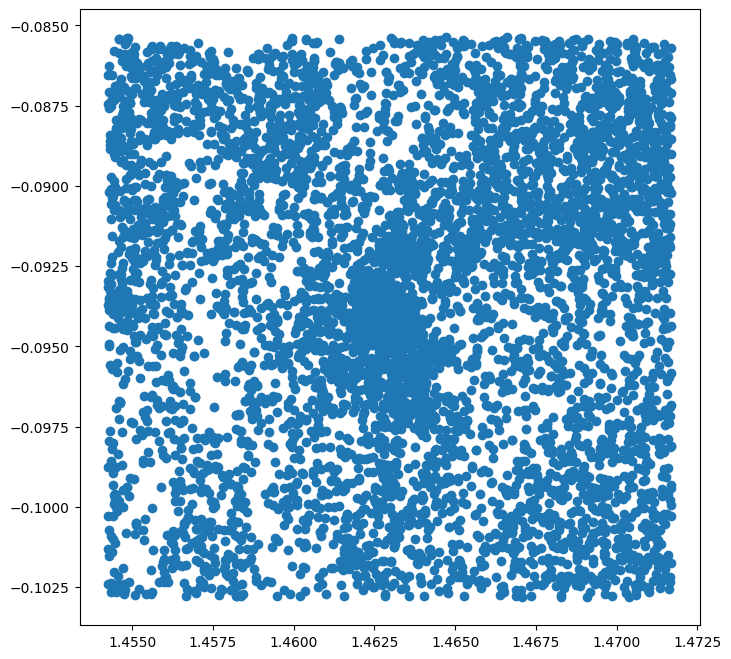

In [49]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:, :])

ra = query["ra"]
ra_err = query["ra_error"].to(u.degree)
dec = query["dec"]
dec_err = query["dec_error"].to(u.degree)

positions = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
ra_rad = positions.ra.wrap_at(180 * u.deg).radian
dec_rad = positions.dec.radian

ax.errorbar(ra_rad, dec_rad, yerr = dec_err.value , xerr=ra_err.value, lw=0, elinewidth=3, marker='o')
# ax.set_xlabel(r"RA [deg]")
# ax.set_ylabel(r"DEC [deg]")
